In [ ]:
colors = [
    "#4b2e83",  # Purple
    "#b7a57a",  # Gold
    "#d9d9d6",  # Light Gray
    "#5e6a71",  # UW Dark Gray
    "#000000",  # Black
    "#ffffff",  
    "#85754d",  
    "#cfcfcd"   
]
cai_colors = ["#8D68F3",
              "#B7CEF9",
              "#F9C952",
              "#A98DF6",
              "#BFD5FF",
              "#FFD365",
              "#535559"]

# Load libraries

In [ ]:
import pandas as pd
import numpy as np

In [4]:
from gql import gql
import json
import pandas as pd
import sys
import warnings
from sqlalchemy import text
import re
from tqdm import tqdm

sys.path.append('../src') 
from connect_psql import connect_psql


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
tqdm.pandas()

# Load data

* 2025-05-01 00:00-23:00

In [ ]:
"""
engine = connect_psql()
with engine.connect() as conn:
    query = text('SELECT * FROM research."usage_analysis_May2025"')
    df_merged = pd.read_sql_query(query, conn)
"""

df_merged = pd.read_csv('../input/sample.csv')
len(df_merged)

104529

In [8]:
df_merged['created_date'] = pd.to_datetime(df_merged['created'], unit='ms', errors='coerce')
df_merged['created_date'].max()

Timestamp('2025-05-29 23:59:57.581000')

In [ ]:
qual_map = pd.read_csv('qual_map.csv')
qual_map.head()

In [10]:
df_merged = df_merged[~df_merged['conversationId'].isna()]
len(df_merged)

104266

In [11]:
len(df_merged['conversationId'].unique())

13071

# Figure 1. Domain Distribution Across Conversations (Filtered for Teacher Requests Only)

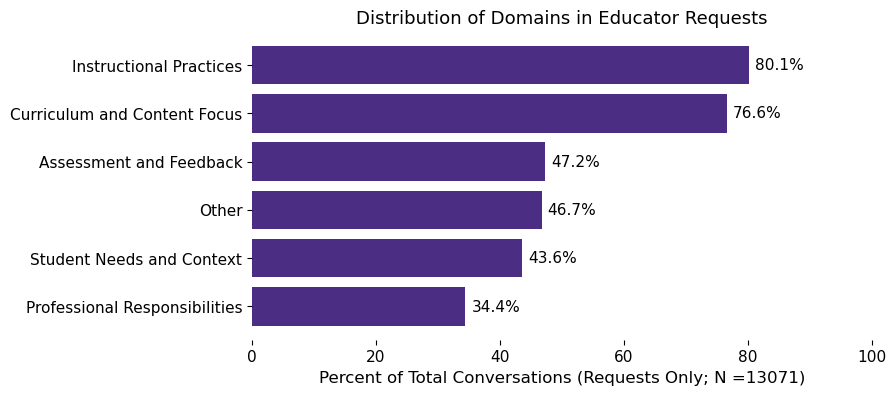

In [ ]:
# 0. Filter only teacher requests
request_df = df_merged[df_merged["type"] == "request"].copy()

# 1. Identify coded item columns
coded_items = qual_map["updated_items"].unique().tolist()
item_cols = [col for col in request_df.columns if col in coded_items]

# 2. Melt to long format where item is present
long_df = (
    request_df[["conversationId"] + item_cols]
    .melt(id_vars="conversationId", value_vars=item_cols,
          var_name="updated_items", value_name="present")
    .query("present == 1")
)

# 3. Merge with qual_map
merged = long_df.merge(qual_map, on="updated_items", how="left")

# 4. Get valid conversations that have at least one coded item
coded_conversations = merged["conversationId"].unique()
total_coded_conversations = len(coded_conversations)

# 5. Separate and count Category 1
cat1_df = merged[["conversationId", "Category 1"]].dropna().drop_duplicates()
cat1_df.columns = ["conversationId", "Category"]

# 6. Separate and count Category 2
cat2_df = merged[["conversationId", "Category 2"]].dropna().drop_duplicates()
cat2_df.columns = ["conversationId", "Category"]

# 7. Combine both categories
all_cats = pd.concat([cat1_df, cat2_df]).drop_duplicates()

# 8. Count unique conversations per category
category_counts = (
    all_cats.groupby("Category")["conversationId"]
    .nunique()
    .sort_values(ascending=True)
)

# 9. Convert to percentage
category_percent = (category_counts / total_coded_conversations * 100).round(1)

# 10. Plot
plt.figure(figsize=(8, 4))
bars = plt.barh(category_percent.index, category_percent.values, color=colors[0])

# Add percentage labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2,
             f"{width:.1f}%", va='center', fontsize=11)

# Final touches
plt.xlabel("Percent of Total Conversations (Requests Only; N =13071)", fontsize=12)
plt.title("Distribution of Domains in Educator Requests", fontsize=13)
plt.xlim(0, 100)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Remove frame/spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.show()

# Figure 2. Distribution of Instructional Groups in Educator Requests

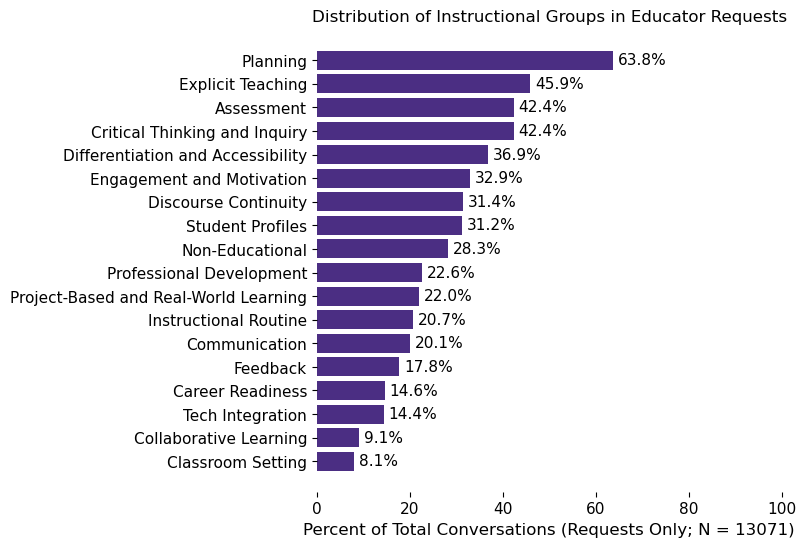

In [ ]:
# 0. Filter only teacher requests
request_df = df_merged[df_merged["type"] == "request"].copy()

# 1. Identify coded item columns
coded_items = qual_map["updated_items"].unique().tolist()
item_cols = [col for col in request_df.columns if col in coded_items]

# 2. Melt to long format where item is present
long_df = (
    request_df[["conversationId"] + item_cols]
    .melt(id_vars="conversationId", value_vars=item_cols,
          var_name="updated_items", value_name="present")
    .query("present == 1")
)

# 3. Merge with qual_map to attach Group
merged = long_df.merge(qual_map, on="updated_items", how="left")

# 4. Drop duplicate (conversationId, Group) pairs
group_df = merged[["conversationId", "Group"]].dropna().drop_duplicates()

# 5. Count unique conversations per Group
group_counts = (
    group_df.groupby("Group")["conversationId"]
    .nunique()
    .sort_values(ascending=True)
)

# 6. Normalize by total number of ALL conversations (not just request_df)
total_conversations = df_merged["conversationId"].nunique()
group_percent = (group_counts / total_conversations * 100).round(1)

# 7. Plot
plt.figure(figsize=(6, 6))
bars = plt.barh(group_percent.index, group_percent.values, color=colors[0])

# Add percentage labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height() / 2,
             f"{width:.1f}%", va='center', fontsize=11)

# Style and labels
plt.xlabel(f"Percent of Total Conversations (Requests Only; N = {total_conversations})", fontsize=12)
plt.title("Distribution of Instructional Groups in Educator Requests", fontsize=12)
plt.xlim(0, 100)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Remove frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.show()




# Figure 3. Distribution of Instructional Groups in Educator Requests and AI Responses

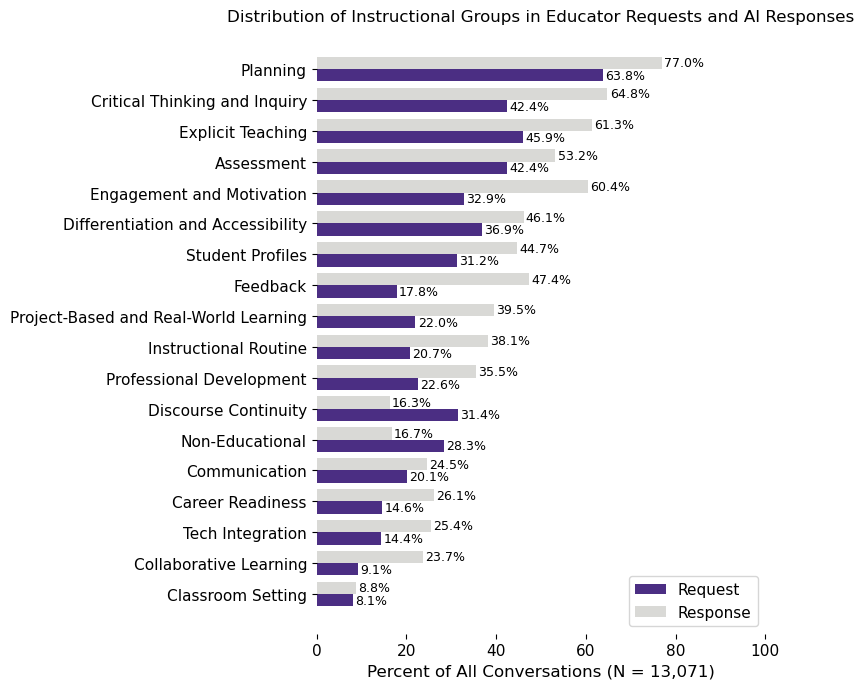

In [ ]:
# 0. Identify coded item columns
coded_items = qual_map["updated_items"].unique().tolist()
item_cols = [col for col in df_merged.columns if col in coded_items]

# 1. Melt to long format for both request and response
long_df = (
    df_merged[["conversationId", "type"] + item_cols]
    .melt(id_vars=["conversationId", "type"], value_vars=item_cols,
          var_name="updated_items", value_name="present")
    .query("present == 1")
)

# 2. Merge with qual_map to get Group
merged = long_df.merge(qual_map, on="updated_items", how="left").dropna(subset=["Group"])

# 3. Deduplicate (conversationId, Group, type)
group_df = merged[["conversationId", "Group", "type"]].drop_duplicates()

# 4. Count group frequency by message type
group_counts = (
    group_df.groupby(["Group", "type"])["conversationId"]
    .nunique()
    .unstack(fill_value=0)
)

# 5. Normalize by total number of conversations
total_conversations = df_merged["conversationId"].nunique()
group_percent = (group_counts / total_conversations * 100).round(1)

# 6. Sort by total across both types
group_percent["Total"] = group_percent.sum(axis=1)
group_percent = group_percent.sort_values("Total", ascending=True).drop(columns="Total")

# 7. Plot side-by-side horizontal bars
plt.figure(figsize=(8, 7))
bar_width = 0.4
y = np.arange(len(group_percent))

plt.barh(y - bar_width / 2, group_percent["request"], height=bar_width,
         label="Request", color=colors[0])
plt.barh(y + bar_width / 2, group_percent["response"], height=bar_width,
         label="Response", color=colors[2])

# Add labels
for i, val in enumerate(group_percent["request"]):
    if val > 0:
        plt.text(val + 0.5, y[i] - bar_width / 2, f"{val:.1f}%", va='center', fontsize=9)

for i, val in enumerate(group_percent["response"]):
    if val > 0:
        plt.text(val + 0.5, y[i] + bar_width / 2, f"{val:.1f}%", va='center', fontsize=9)

# Formatting
plt.yticks(y, group_percent.index, fontsize=11)
plt.xticks(fontsize=11)
plt.xlabel("Percent of All Conversations (N = 13,071)", fontsize=12)
plt.title("Distribution of Instructional Groups in Educator Requests and AI Responses", fontsize=12)
plt.xlim(0, 100)
plt.legend(loc="lower right", fontsize=11)

# Remove frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()


# Figure 4 Instructional Group Co-Occurrence in Teacher–AI Conversations (Percentage of All Conversations)
In 7.3% of the total conversations (~954 conversations), both Assessment and Career Readiness were present in the same conversation.

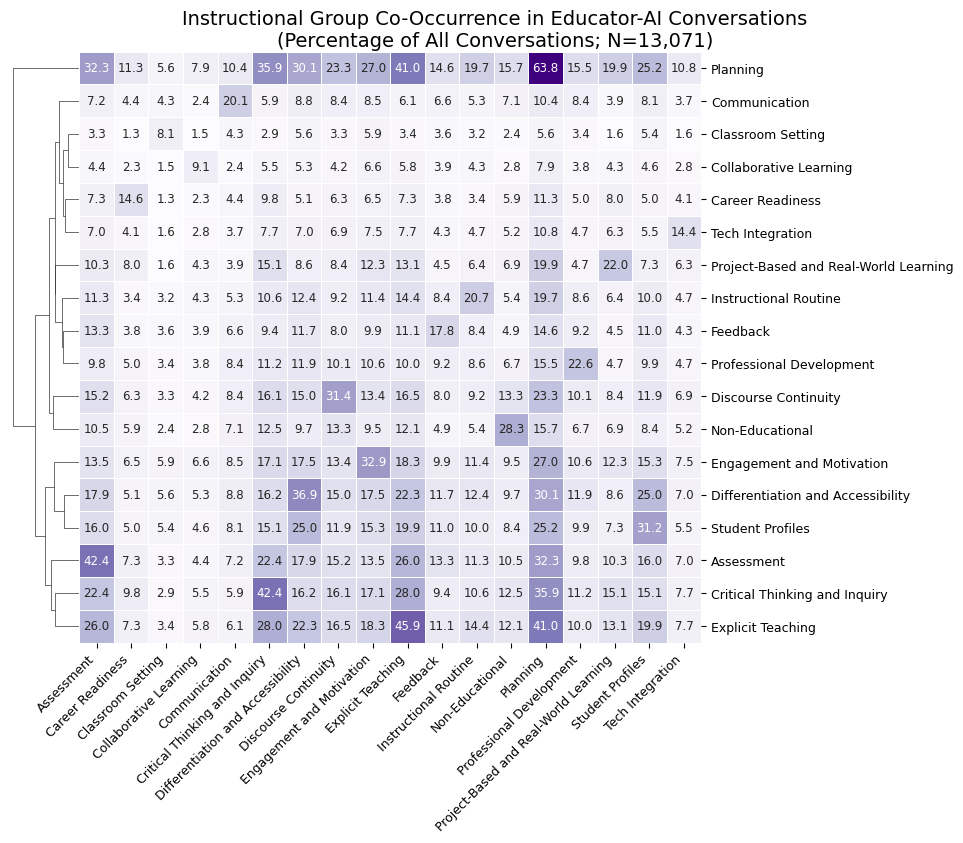

In [46]:
# 0. Filter teacher requests
request_df = df_merged[df_merged["type"] == "request"].copy()

# 1. Identify coded item columns
coded_items = qual_map["updated_items"].unique().tolist()
item_cols = [col for col in request_df.columns if col in coded_items]

# 2. Melt to long format for present items
long_df = (
    request_df[["conversationId"] + item_cols]
    .melt(id_vars="conversationId", value_vars=item_cols,
          var_name="updated_items", value_name="present")
    .query("present == 1")
)

# 3. Merge with qual_map to attach Group
merged = long_df.merge(qual_map, on="updated_items", how="left").dropna(subset=["Group"])

# 4. For each conversation, get unique list of groups
group_per_convo = (
    merged[["conversationId", "Group"]]
    .drop_duplicates()
    .groupby("conversationId")["Group"]
    .apply(list)
)

# 5. Create co-occurrence matrix
from itertools import combinations
from collections import Counter
import pandas as pd

co_occurrence = Counter()
for groups in group_per_convo:
    unique = set(groups)
    for g1 in unique:
        for g2 in unique:
            co_occurrence[(g1, g2)] += 1

# 6. Convert to DataFrame
group_labels = sorted(set(merged["Group"]))
matrix = pd.DataFrame(index=group_labels, columns=group_labels, dtype=int).fillna(0)

for (g1, g2), count in co_occurrence.items():
    matrix.loc[g1, g2] = count

# 7. Normalize by total number of conversations
total_conversations = df_merged["conversationId"].nunique()
matrix_percent = (matrix / total_conversations * 100).round(1)

g = sns.clustermap(
    matrix_percent,
    cmap="Purples",
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    figsize=(10, 9),
    cbar=False,
    dendrogram_ratio=(0.1, 0.0),  
    row_cluster=True,
    col_cluster=False, 
    annot_kws={"size": 8.5}
)

# Manually hide colorbar (workaround for clustermap bug)
g.cax.set_visible(False)

plt.suptitle("Instructional Group Co-Occurrence in Educator-AI Conversations\n(Percentage of All Conversations; N=13,071)", fontsize=14, y=1.03)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=9)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=9)

plt.show()

# Figure 5

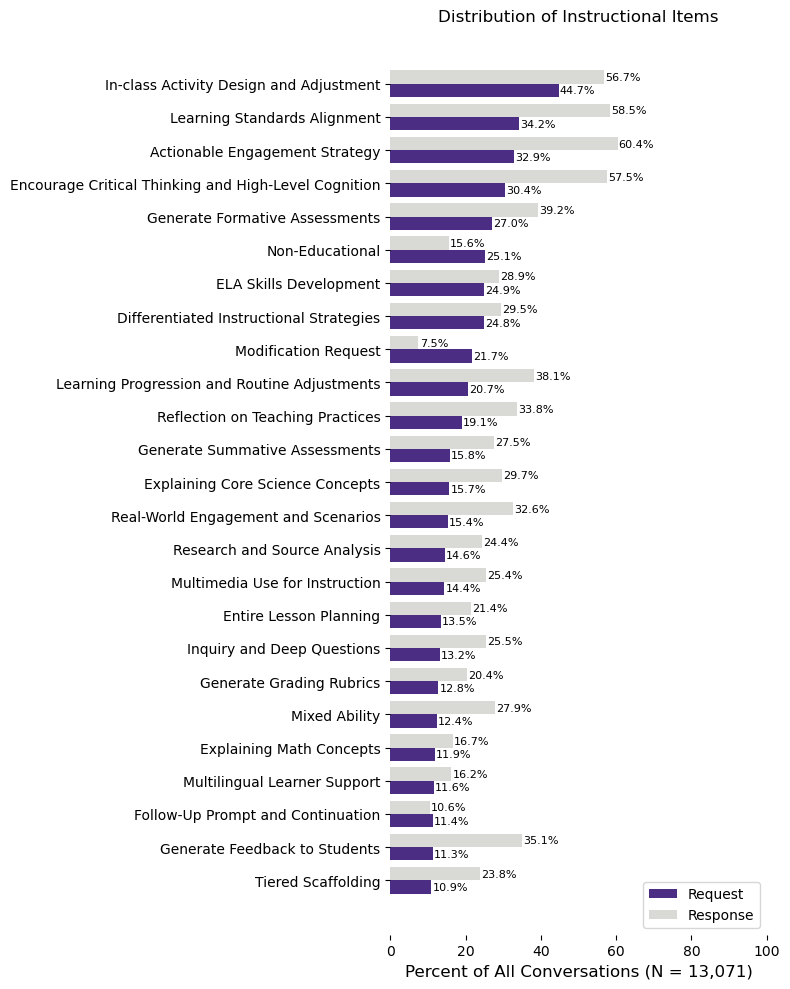

In [ ]:
# 0. Identify coded item columns
coded_items = qual_map["updated_items"].unique().tolist()
item_cols = [col for col in df_merged.columns if col in coded_items]

# 1. Melt to long format for both request and response
long_df = (
    df_merged[["conversationId", "type"] + item_cols]
    .melt(id_vars=["conversationId", "type"], value_vars=item_cols,
          var_name="updated_items", value_name="present")
    .query("present == 1")
)

# 2. Deduplicate (conversationId, updated_item, type)
item_df = long_df[["conversationId", "updated_items", "type"]].drop_duplicates()

# 3. Count frequency by type
item_counts = (
    item_df.groupby(["updated_items", "type"])["conversationId"]
    .nunique()
    .unstack(fill_value=0)
)

# 4. Normalize by total number of conversations
total_conversations = df_merged["conversationId"].nunique()
item_percent = (item_counts / total_conversations * 100).round(1)

# 5. Select top 25 by request
item_percent["request_rank"] = item_percent["request"]
item_percent = item_percent.sort_values("request_rank", ascending=False).head(25)
item_percent = item_percent.drop(columns=["request_rank"])
item_percent = item_percent.sort_values("request", ascending=True)

# 6. Plot
plt.figure(figsize=(8, 10))
bar_width = 0.4
y = np.arange(len(item_percent))

plt.barh(y - bar_width / 2, item_percent["request"], height=bar_width,
         label="Request", color=colors[0])
plt.barh(y + bar_width / 2, item_percent["response"], height=bar_width,
         label="Response", color=colors[2])

# Add labels
for i, val in enumerate(item_percent["request"]):
    if val > 0:
        plt.text(val + 0.3, y[i] - bar_width / 2, f"{val:.1f}%", va='center', fontsize=8)

for i, val in enumerate(item_percent["response"]):
    if val > 0:
        plt.text(val + 0.3, y[i] + bar_width / 2, f"{val:.1f}%", va='center', fontsize=8)

# Formatting
plt.yticks(y, item_percent.index, fontsize=10)
plt.xticks(fontsize=10)
plt.xlabel("Percent of All Conversations (N = 13,071)", fontsize=12)
plt.title("Distribution of Instructional Items", fontsize=12)
plt.xlim(0, 100)
plt.legend(loc="lower right", fontsize=10)

# Remove frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()
